In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 1000) # Show all columns

# Preselection of Features

In [4]:
#df = pd.read_csv('/Users/z3/Documents/Studium/1. Semester/ProbML/EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv')

In [8]:
#selected_df = df[['STATEFP','COUNTYFP','TRACTCE','BLKGRPCE','CSA','CSA_Name','CBSA','CBSA_Name','CBSA_POP','CBSA_EMP','CBSA_WRK','TotPop','HH','P_WrkAge','Pct_AO0','Workers','R_PCTLOWWAGE','TotEmp','E_PctLowWage','D1A','D1B','D1C','D2A_JPHH','D3AAO','D4A','D4C']].rename(columns={
#'STATEFP': 'STATE_ID','COUNTYFP': 'COUNTY_ID','TRACTCE':'Tract_ID','BLKGRPCE':'Block_Group','CSA': 'CSA','CSA_Name': 'CSA_NAME','CBSA': 'CBSA','CBSA_Name': 'CBSA_NAME','CBSA_POP': 'CBSA_POP','CBSA_EMP': 'CBSA_EMP','CBSA_WRK': 'CBSA_WRK','TotPop': 'TOTAL_POPULATION','HH': 'HOUSEHOLDS','P_WrkAge': 'P_WORKING_AGE','Pct_AO0': 'P_ZERO_CARS_HOUSEHOLDS','Workers': 'WORKERS','R_PCTLOWWAGE': 'P_LOW_WAGE_WORKERS','TotEmp': 'TOTAL_EMPLOYMENT','E_PctLowWage': 'P_LOW_WAGE_EMPLOYMENT','D1A': 'HOUSEHOLD_P_ACRE','D1B': 'POPULATION_P_ACRE','D1C': 'JOBS_P_ACRE', 'D2A_JPHH' : 'JOBS_P_HOUSEHOLD','D3AAO': 'ROAD_NETWORK_MILES_AUTO','D4A': 'METERS_NEXT_TRANSIT_ STOP','D4C': 'TIMES_P_HOUR_TRANSIT_SERVICE'})


In [10]:
#selected_df.to_csv('census_data', index=False) 

# COMMENT:

You are still lacking a detailed description of the source and meaning of the data. Something like this would be helpful:

"The data source is XXX, and it contains information about YYY for the period ZZZ. It contains a number of F features. etc etc etc."


## but this overall verbal description, together with the summarized numerical description of the features, is needed in a clean way in the report

# Load

In [13]:
# Load csv 
df_org = pd.read_csv('/Users/z3/Documents/Studium/1. Semester/ProbML/Probabilistic-Machine-Learning_lecture-PROJECTS/projects/15-2BLXXXX_epa_census/data/census_data')

# First Overview

In [15]:
df = df_org.copy()

# Data Preperation

## Null-Values

In [20]:
df.isnull().sum()

STATE_ID                            0
COUNTY_ID                           0
Tract_ID                            0
Block_Group                         0
CSA                             53031
CSA_NAME                        53031
CBSA                            17095
CBSA_NAME                       17095
CBSA_POP                            0
CBSA_EMP                            0
CBSA_WRK                            0
TOTAL_POPULATION                    0
HOUSEHOLDS                        275
P_WORKING_AGE                       0
P_ZERO_CARS_HOUSEHOLDS              0
WORKERS                             0
P_LOW_WAGE_WORKERS                  0
TOTAL_EMPLOYMENT                    0
P_LOW_WAGE_EMPLOYMENT               0
HOUSEHOLD_P_ACRE                  271
POPULATION_P_ACRE                   0
JOBS_P_ACRE                         0
JOBS_P_HOUSEHOLD                    0
ROAD_NETWORK_MILES_AUTO             0
METERS_NEXT_TRANSIT_ STOP           0
TIMES_P_HOUR_TRANSIT_SERVICE        0
dtype: int64

## Missing CSA and CBSA Values
I have a lot of Null-Values in CSA and CBSA Columns. These are just additional location information and no features. I will not use them in the model. They are just useful to get information about individual elements.

## Missing Households Values

In [24]:
# Comparing households_null_values with special_territories with state identity 66 and 69

households_null_df = df[df['HOUSEHOLDS'].isnull() | df['HOUSEHOLD_P_ACRE'].isnull()]
special_territories_df = df[df['STATE_ID'].isin([66, 69])] 

same_indices = households_null_df.index.equals(special_territories_df.index)
print(same_indices)  # True if exactly same rows selected

True


The values match the total number of elements from "Northern Mariana Islands" and "Guam". Because they are missing in total and this are special territories, I would drop them. I also would drop other special territories which are not American states:

In [27]:
# Drop all special territories
df = df[df['STATE_ID']<=56] 

## Data Description

In [30]:
df.describe()

,STATE_ID,COUNTY_ID,Tract_ID,Block_Group,CSA,CBSA,CBSA_POP,CBSA_EMP,CBSA_WRK,TOTAL_POPULATION,HOUSEHOLDS,P_WORKING_AGE,P_ZERO_CARS_HOUSEHOLDS,WORKERS,P_LOW_WAGE_WORKERS,TOTAL_EMPLOYMENT,P_LOW_WAGE_EMPLOYMENT,HOUSEHOLD_P_ACRE,POPULATION_P_ACRE,JOBS_P_ACRE,JOBS_P_HOUSEHOLD,ROAD_NETWORK_MILES_AUTO,METERS_NEXT_TRANSIT_ STOP,TIMES_P_HOUR_TRANSIT_SERVICE
count,217739.000000,217739.000000,217739.000000,217739.000000,165358.000000,201066.000000,2.177390e+05,2.177390e+05,2.177390e+05,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000
mean,28.032071,85.893896,260341.890681,2.222836,339.877611,30438.240379,3.640101e+06,1.706534e+06,1.657484e+06,1482.982056,549.879112,0.596186,0.092067,646.607498,0.237747,647.915008,0.295959,4.525163,10.445416,3.825622,1.793225,0.987918,-56542.004006,-53413.498352
std,15.697888,99.319321,350582.092807,1.195316,125.530744,10955.270410,5.246923e+06,2.487643e+06,2.409038e+06,990.394957,339.914770,0.102778,0.135699,416.995859,0.056450,2033.839914,0.151614,13.938563,29.280778,46.708921,38.854630,2.407022,49768.726104,49889.750594
min,1.000000,1.000000,100.000000,0.000000,104.000000,10100.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-99999.000000,-99999.000000
25%,13.000000,29.000000,10300.000000,1.000000,216.000000,19740.000000,2.058140e+05,8.365800e+04,8.366200e+04,891.000000,342.000000,0.544000,0.010289,391.000000,0.203509,73.000000,0.191916,0.295216,0.701898,0.085160,0.151659,0.000000,-99999.000000,-99999.000000
50%,28.000000,61.000000,43900.000000,2.000000,356.000000,32580.000000,1.252890e+06,5.950500e+05,5.656950e+05,1267.000000,477.000000,0.595000,0.043400,555.000000,0.232787,205.000000,0.281481,1.841697,4.318367,0.555907,0.406849,0.026931,-99999.000000,-99999.000000
75%,41.000000,109.000000,480400.000000,3.000000,428.000000,39150.000000,4.673634e+06,2.400290e+06,2.241034e+06,1818.000000,674.000000,0.649000,0.113757,797.000000,0.267123,557.000000,0.381818,4.140478,10.095174,2.200705,1.070707,0.821117,346.010000,4.670000
max,56.000000,840.000000,992201.000000,9.000000,566.000000,49820.000000,1.931847e+07,9.159786e+06,8.946175e+06,55407.000000,21337.000000,1.000000,1.000000,19255.000000,1.000000,266101.000000,1.000000,1481.257220,3133.578265,14032.760640,12325.666670,107.987669,1207.000000,973.670000


### High Values of population

In [33]:
df[df['TOTAL_POPULATION']>30000]

,STATE_ID,COUNTY_ID,Tract_ID,Block_Group,CSA,CSA_NAME,CBSA,CBSA_NAME,CBSA_POP,CBSA_EMP,CBSA_WRK,TOTAL_POPULATION,HOUSEHOLDS,P_WORKING_AGE,P_ZERO_CARS_HOUSEHOLDS,WORKERS,P_LOW_WAGE_WORKERS,TOTAL_EMPLOYMENT,P_LOW_WAGE_EMPLOYMENT,HOUSEHOLD_P_ACRE,POPULATION_P_ACRE,JOBS_P_ACRE,JOBS_P_HOUSEHOLD,ROAD_NETWORK_MILES_AUTO,METERS_NEXT_TRANSIT_ STOP,TIMES_P_HOUR_TRANSIT_SERVICE
1232,48,157,672900,1,288.0,"Houston-The Woodlands, TX",26420.0,"Houston-The Woodlands-Sugar Land, TX",6779104,2975382,2886903,51536,15407.0,0.627,0.002402,18918,0.186330,3017,0.421279,1.374236,4.410976,0.258226,0.195820,2.172175,-99999.00,-99999.00
14654,48,157,673101,1,288.0,"Houston-The Woodlands, TX",26420.0,"Houston-The Woodlands-Sugar Land, TX",6779104,2975382,2886903,55407,15298.0,0.561,0.010132,14430,0.152460,17541,0.202839,1.742049,6.051140,1.915697,1.146620,0.782986,-99999.00,-99999.00
41412,6,73,18700,1,NaN,NaN,41740.0,"San Diego-Chula Vista-Carlsbad, CA",3302833,1403191,1419381,38932,6877.0,0.748,0.000000,6608,0.236229,1848,0.174242,0.057605,0.293930,0.013952,0.268722,0.207709,-99999.00,12.00
63625,12,119,911200,1,422.0,"Orlando-Lakeland-Deltona, FL",45540.0,"The Villages, FL",120999,25547,23986,39919,21337.0,0.198,0.015091,5856,0.400615,5409,0.317989,2.401617,3.626500,0.491389,0.253503,0.480288,-99999.00,-99999.00
69848,12,95,16730,1,422.0,"Orlando-Lakeland-Deltona, FL",36740.0,"Orlando-Kissimmee-Sanford, FL",2450261,1262313,1135710,31938,10189.0,0.603,0.024438,14402,0.205458,2278,0.366550,1.970425,5.639018,0.402207,0.223574,0.501612,-99999.00,0.33
170662,38,17,40500,2,244.0,"Fargo-Wahpeton, ND-MN",22020.0,"Fargo, ND-MN",237003,137770,122263,39283,15893.0,0.665,0.032908,19255,0.188990,11131,0.250292,0.565242,1.300023,0.368367,0.700371,0.443921,380.88,3.00


Unusually high values of population checked; Example Element 14654 validated by https://datacommons.org/browser/geoId/481576731011

## Feature Engineering

### Threshold Values for Transit Features

##### METERS_NEXT_TRANSIT_ STOP

'All CBGs with population-weighted centroids that were further than three-quarter miles (1.2 km) from a transit stop were assigned a value of “-99999.”'

This are bad placeholders because it should be a high positive value to show that a transit stop is far away

In [39]:
#df[df['METERS_NEXT_TRANSIT_ STOP']==-99999]

##### TIMES_P_HOUR_TRANSIT_SERVICE

'CBGs in areas that do not have transit service were assigned the value “-99999.”'

This are bad placeholders because it should be a zero to show that there is 0 times per hour

In [42]:
#df[df['TIMES_P_HOUR_TRANSIT_SERVICE']==-99999]

In [44]:
# Replacing placeholder values with null
df['METERS_NEXT_TRANSIT_ STOP'] = df['METERS_NEXT_TRANSIT_ STOP'].replace(-99999, np.nan)
df['TIMES_P_HOUR_TRANSIT_SERVICE'] = df['TIMES_P_HOUR_TRANSIT_SERVICE'].replace(-99999, np.nan)

# Create new binary feature no_transit
df.loc[:, 'no_transit'] = df['METERS_NEXT_TRANSIT_ STOP'].isna().astype(int)

# Fill Features with suiting values
df.loc[:, 'METERS_NEXT_TRANSIT_ STOP'] = df['METERS_NEXT_TRANSIT_ STOP'].fillna(2000) # max of other data is 1200
df.loc[:, 'TIMES_P_HOUR_TRANSIT_SERVICE'] = df['TIMES_P_HOUR_TRANSIT_SERVICE'].fillna(0) # minimum value of zero

In [46]:
df.describe()

,STATE_ID,COUNTY_ID,Tract_ID,Block_Group,CSA,CBSA,CBSA_POP,CBSA_EMP,CBSA_WRK,TOTAL_POPULATION,HOUSEHOLDS,P_WORKING_AGE,P_ZERO_CARS_HOUSEHOLDS,WORKERS,P_LOW_WAGE_WORKERS,TOTAL_EMPLOYMENT,P_LOW_WAGE_EMPLOYMENT,HOUSEHOLD_P_ACRE,POPULATION_P_ACRE,JOBS_P_ACRE,JOBS_P_HOUSEHOLD,ROAD_NETWORK_MILES_AUTO,METERS_NEXT_TRANSIT_ STOP,TIMES_P_HOUR_TRANSIT_SERVICE,no_transit
count,217739.000000,217739.000000,217739.000000,217739.000000,165358.000000,201066.000000,2.177390e+05,2.177390e+05,2.177390e+05,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000
mean,28.032071,85.893896,260341.890681,2.222836,339.877611,30438.240379,3.640101e+06,1.706534e+06,1.657484e+06,1482.982056,549.879112,0.596186,0.092067,646.607498,0.237747,647.915008,0.295959,4.525163,10.445416,3.825622,1.793225,0.987918,1331.240828,6.806150,0.567390
std,15.697888,99.319321,350582.092807,1.195316,125.530744,10955.270410,5.246923e+06,2.487643e+06,2.409038e+06,990.394957,339.914770,0.102778,0.135699,416.995859,0.056450,2033.839914,0.151614,13.938563,29.280778,46.708921,38.854630,2.407022,787.794129,22.654669,0.495439
min,1.000000,1.000000,100.000000,0.000000,104.000000,10100.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,29.000000,10300.000000,1.000000,216.000000,19740.000000,2.058140e+05,8.365800e+04,8.366200e+04,891.000000,342.000000,0.544000,0.010289,391.000000,0.203509,73.000000,0.191916,0.295216,0.701898,0.085160,0.151659,0.000000,457.320000,0.000000,0.000000
50%,28.000000,61.000000,43900.000000,2.000000,356.000000,32580.000000,1.252890e+06,5.950500e+05,5.656950e+05,1267.000000,477.000000,0.595000,0.043400,555.000000,0.232787,205.000000,0.281481,1.841697,4.318367,0.555907,0.406849,0.026931,2000.000000,0.000000,1.000000
75%,41.000000,109.000000,480400.000000,3.000000,428.000000,39150.000000,4.673634e+06,2.400290e+06,2.241034e+06,1818.000000,674.000000,0.649000,0.113757,797.000000,0.267123,557.000000,0.381818,4.140478,10.095174,2.200705,1.070707,0.821117,2000.000000,4.670000,1.000000
max,56.000000,840.000000,992201.000000,9.000000,566.000000,49820.000000,1.931847e+07,9.159786e+06,8.946175e+06,55407.000000,21337.000000,1.000000,1.000000,19255.000000,1.000000,266101.000000,1.000000,1481.257220,3133.578265,14032.760640,12325.666670,107.987669,2000.000000,973.670000,1.000000


### <span style="color:yellow">Question: </span>

I have a lot of elements which have no_transit: 50% quantile. Does this effect my regression in any way?

# Correlation

In [50]:
correlation_matrix = df.iloc[:, 7:].corr(numeric_only=True)

In [51]:
correlation_matrix

,CBSA_POP,CBSA_EMP,CBSA_WRK,TOTAL_POPULATION,HOUSEHOLDS,P_WORKING_AGE,P_ZERO_CARS_HOUSEHOLDS,WORKERS,P_LOW_WAGE_WORKERS,TOTAL_EMPLOYMENT,P_LOW_WAGE_EMPLOYMENT,HOUSEHOLD_P_ACRE,POPULATION_P_ACRE,JOBS_P_ACRE,JOBS_P_HOUSEHOLD,ROAD_NETWORK_MILES_AUTO,METERS_NEXT_TRANSIT_ STOP,TIMES_P_HOUR_TRANSIT_SERVICE,no_transit
CBSA_POP,1.000000,0.999034,0.999158,0.028740,-0.011482,0.086897,0.311733,0.074224,-0.253842,0.021866,-0.031438,0.359270,0.404855,0.084163,0.005041,0.099080,-0.392491,0.381475,-0.372558
CBSA_EMP,0.999034,1.000000,0.999581,0.024783,-0.013377,0.088860,0.313602,0.073326,-0.255802,0.022114,-0.032652,0.359782,0.405421,0.084676,0.005076,0.097448,-0.391507,0.383420,-0.370785
CBSA_WRK,0.999158,0.999581,1.000000,0.024349,-0.013815,0.087624,0.317184,0.072787,-0.255992,0.021555,-0.033224,0.361855,0.407303,0.085071,0.004974,0.096482,-0.391425,0.385854,-0.370596
TOTAL_POPULATION,0.028740,0.024783,0.024349,1.000000,0.899984,0.052358,-0.107892,0.887816,-0.129551,0.117587,-0.008689,-0.004934,0.026318,-0.001909,-0.009456,0.029727,0.073889,-0.010974,0.057537
HOUSEHOLDS,-0.011482,-0.013377,-0.013815,0.899984,1.000000,0.069912,-0.059571,0.865111,-0.158006,0.154710,-0.011071,0.045256,0.025741,0.010242,-0.026307,0.046804,0.075377,0.022562,0.062556
P_WORKING_AGE,0.086897,0.088860,0.087624,0.052358,0.069912,1.000000,0.089368,0.108538,-0.035057,0.077061,0.016239,0.139902,0.127748,0.055041,0.015692,0.074612,-0.215141,0.159774,-0.199135
P_ZERO_CARS_HOUSEHOLDS,0.311733,0.313602,0.317184,-0.107892,-0.059571,0.089368,1.000000,-0.131412,0.189584,0.062016,-0.008370,0.497099,0.498522,0.144962,0.011384,0.078973,-0.371599,0.509501,-0.307307
WORKERS,0.074224,0.073326,0.072787,0.887816,0.865111,0.108538,-0.131412,1.000000,-0.242166,0.133512,-0.014105,0.001037,0.008873,0.003790,-0.015563,0.043936,0.058003,0.002011,0.036920
P_LOW_WAGE_WORKERS,-0.253842,-0.255802,-0.255992,-0.129551,-0.158006,-0.035057,0.189584,-0.242166,1.000000,-0.052776,0.129388,-0.092846,-0.069734,-0.037449,0.007951,-0.041387,0.035610,-0.114924,0.053807
TOTAL_EMPLOYMENT,0.021866,0.022114,0.021555,0.117587,0.154710,0.077061,0.062016,0.133512,-0.052776,1.000000,-0.140428,-0.010235,-0.019860,0.276031,0.185105,0.137668,-0.064263,0.248875,-0.060211


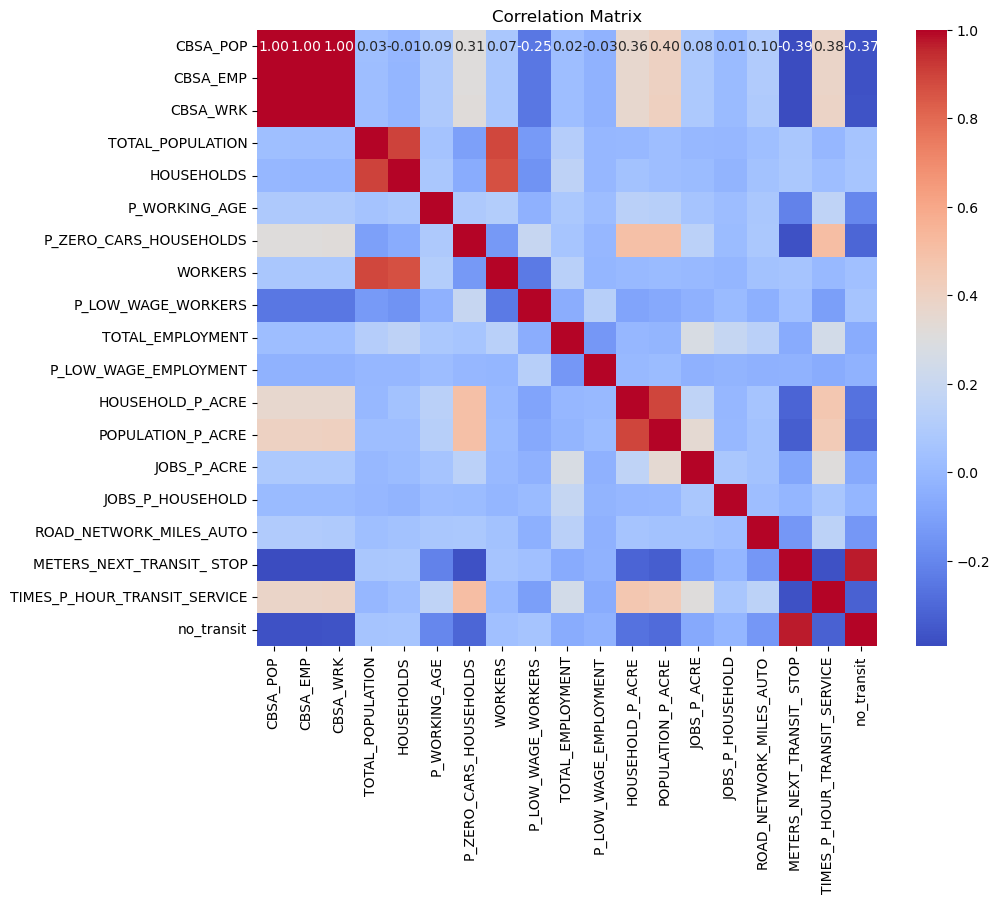

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### <span style="color:yellow">Question: </span>

Do you think I have enough correlation in the features to model P_ZERO_CARS_HOUSEHOLDS?

# COMMENT 
There are definitely some pairs of variables displaying significant correlation, but it is important that you provide a good description of each feature to understand better the nature of this correlation. 

A table of the following form would be helpful:


| Feature Name | Description | Do I suspect is it important for the analysis? | Why? |
| HOUSEHOLDS | Number of households in the CBG | Yes | It is a basic demographic feature that can influence car ownership |
| POPULATION | Total population in the CBG | Yes | Higher population may correlate with lower car ownership due to public transport availability |

and so on for each feature. So please complete this table for all features you are using in the analysis.